In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from simulations.utils.deltacon import deltacon

def pos_part(matrix):
    return np.where(matrix > 0, matrix, 0)

def neg_part(matrix):
    return np.where(matrix < 0, -matrix, 0)

from plot_utils import cool_savefig

In [3]:
number_simulations = 1000
entropy = 42
seed = np.random.SeedSequence(entropy)

In [4]:
def get_matrix(rng):
    """
    We are only interested in Beta distributions with same concentration parameter as uniform,
    that is the same value of concentration as Beta(2*0.5, 2*0.5) = Uniform(0,1)
    """
    hyperparameter = rng.random()
    random_numbers = rng.beta(a=2.*(hyperparameter), b=2.*(1.-hyperparameter),
                             size=(100,100))
    base_random_network = 2. * (random_numbers - 0.5)
    random_mask = rng.integers(low=0, high=2, size=(100,100)).astype(float)
    result = base_random_network * random_mask
    return result

In [5]:
def u_mixed_sign_deltacon(matrix1, matrix2):
    return deltacon(np.sign(matrix1), np.sign(matrix2))

def u_deltacon(matrix1, matrix2):
    return deltacon((matrix1 != 0).astype(float), np.abs(np.sign(matrix2)))

def u_pos_deltacon(matrix1, matrix2):
    return deltacon(pos_part(np.sign(matrix1)), pos_part(np.sign(matrix2)))

def u_neg_deltacon(matrix1, matrix2):
    return deltacon(neg_part(np.sign(matrix1)), neg_part(np.sign(matrix2)))

def w_mixed_sign_deltacon(matrix1, matrix2):
    return deltacon(matrix1, matrix2)

def w_deltacon(matrix1, matrix2):
    return deltacon(np.abs(matrix1), np.abs(matrix2))

def w_pos_deltacon(matrix1, matrix2):
    return deltacon(pos_part(matrix1), pos_part(matrix2))

def w_neg_deltacon(matrix1, matrix2):
    return deltacon(neg_part(matrix1), neg_part(matrix2))

In [6]:
def more_pos_than_neg(matrix):
    num_pos = np.sum(matrix > 0)
    num_neg = np.sum(matrix < 0)
    
    return num_pos > num_neg

# The idea here is to ignore at least for now those matrices with num_pos == num_neg

def more_neg_than_pos(matrix):
    num_pos = np.sum(matrix > 0)
    num_neg = np.sum(matrix < 0)
    
    return num_neg > num_pos

In [7]:
def reds(index): return sns.color_palette("Reds", 10)[index]
def greens(index): return sns.color_palette("Greens", 10)[index]
weird_red = sns.color_palette("magma", 7)[4]
weird_green = sns.color_palette("viridis", 7)[6]

def plot_attack(random_matrices, attack_function, title='Attack',
                variants=["u_dom_deltacon", "u_sub_deltacon", "u_mixed_sign_deltacon",
                          "w_dom_deltacon", "w_sub_deltacon", "w_mixed_sign_deltacon",
                         "u_deltacon", "w_deltacon"], **plot_kwargs):
    
    attacked_matrices = [(matrix, attack_function(matrix)) for matrix in random_matrices]
    pos_dom_attackeds = [pair for pair in attacked_matrices if more_pos_than_neg(pair[0])]
    neg_dom_attackeds = [pair for pair in attacked_matrices if more_neg_than_pos(pair[0])]
    attacked_matrices = pos_dom_attackeds + neg_dom_attackeds
    
    deltacon_values = {
    "u_dom_deltacon": np.asarray([u_pos_deltacon(*pair) for pair in pos_dom_attackeds] +
                              [u_neg_deltacon(*pair) for pair in neg_dom_attackeds]),
    "u_sub_deltacon": np.asarray([u_neg_deltacon(*pair) for pair in pos_dom_attackeds] +
                              [u_pos_deltacon(*pair) for pair in neg_dom_attackeds]),
    "u_mixed_sign_deltacon": np.asarray([u_mixed_sign_deltacon(*pair) for pair in attacked_matrices]),
    "u_deltacon": np.asarray([u_deltacon(*pair) for pair in attacked_matrices]),
    "w_dom_deltacon": np.asarray([w_pos_deltacon(*pair) for pair in pos_dom_attackeds] +
                              [w_neg_deltacon(*pair) for pair in neg_dom_attackeds]),
    "w_sub_deltacon": np.asarray([w_neg_deltacon(*pair) for pair in pos_dom_attackeds] +
                              [w_pos_deltacon(*pair) for pair in neg_dom_attackeds]),
    "w_mixed_sign_deltacon": np.asarray([w_mixed_sign_deltacon(*pair) for pair in attacked_matrices]),
    "w_deltacon": np.asarray([w_deltacon(*pair) for pair in attacked_matrices]),
    }
    deltacon_values_matrix = np.concatenate([deltacon_values[variant].reshape((-1,1)) 
                                             for variant in variants], axis=1)
    
    color_map = {"u_dom_deltacon": reds(0), "u_mixed_sign_deltacon": weird_red, "u_sub_deltacon": reds(4),
                 "w_dom_deltacon": greens(0), "w_mixed_sign_deltacon": weird_green, "w_sub_deltacon": greens(4),
                "u_deltacon": reds(9), "w_deltacon": greens(9)}
    
    variant_titles = {"u_dom_deltacon": "Dominant Sign Edges", "u_mixed_sign_deltacon": "Mixed-Sign Unweighted",
                     "u_sub_deltacon": "Submissive Sign Edges",
                      "w_dom_deltacon": "Dominant Sign Edges", "w_mixed_sign_deltacon": "Mixed-Sign Weighted",
                     "w_sub_deltacon": "Submissive Sign Edges",
                     "w_deltacon": "Magnitudes Only", "u_deltacon": "Presence/Absence Only"}
    
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(12,8))
        ax = sns.violinplot(data=deltacon_values_matrix, cut=0, 
                            palette=[color_map[variant] for variant in variants], **plot_kwargs)
        ax.set_xticklabels([variant_titles[variant] for variant in variants], fontsize=12)
        ax.set_ylim(bottom=-0.05)
        ax.set_ylabel('Value', fontsize=18)
        ax.set_title(title, fontsize=24)
        cool_savefig(title)
    
def plot_attack_u_variants(random_matrices, attack_function, title='Attack', **plot_kwargs):
    plot_attack(random_matrices, attack_function, title=title,
               variants=["u_dom_deltacon", "u_sub_deltacon", "u_mixed_sign_deltacon"], 
                **plot_kwargs)
    
def plot_attack_w_variants(random_matrices, attack_function, title='Attack', **plot_kwargs):
    plot_attack(random_matrices, attack_function, title=title,
               variants=["w_dom_deltacon", "w_sub_deltacon", "w_mixed_sign_deltacon"], 
                **plot_kwargs)
    
def plot_attack_alts(random_matrices, attack_function, title='Attack', **plot_kwargs):
    plot_attack(random_matrices, attack_function, title=title, 
               variants=["u_mixed_sign_deltacon", "w_mixed_sign_deltacon", "u_deltacon", "w_deltacon"], 
                **plot_kwargs)

In [8]:
%%time
rng = np.random.default_rng(seed)
random_matrices = [get_matrix(rng) for simulation in range(number_simulations)]

CPU times: user 3 s, sys: 62.2 ms, total: 3.06 s
Wall time: 3.06 s


## Shift Attack

For a positive dominated matrix, if we shift all of the entries by a constant such that they are all negative, most of them will have their magnitudes disrupted. In particular this will mess up the relative ordering of the magnitudes substantially.

The attack proceeds similarly for a negative dominated matrix. All entries now become positive.

In [9]:
def shift_attack(matrix):
    num_neg = np.sum(matrix < 0.)
    num_pos = np.sum(matrix > 0.)
    
    result = matrix.copy()
    
    if num_neg > num_pos:
        result[np.nonzero(matrix)] += 2.*np.abs(np.min(matrix, axis=None))
    if num_pos > num_neg:
        result[np.nonzero(matrix)] -= 2.*np.max(matrix, axis=None)
        
    return result

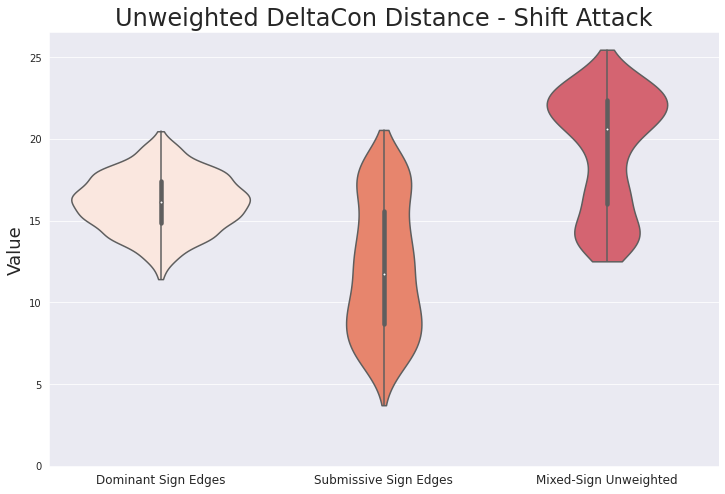

In [10]:
plot_attack_u_variants(random_matrices, shift_attack, title='Unweighted DeltaCon Distance - Shift Attack')

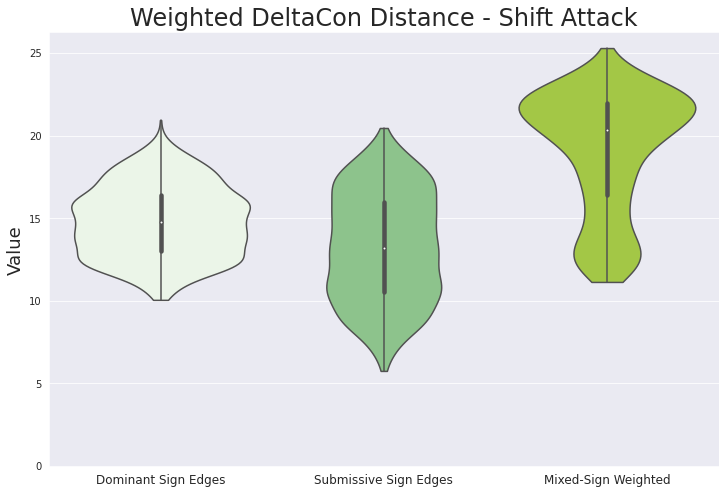

In [11]:
plot_attack_w_variants(random_matrices, shift_attack, title='Weighted DeltaCon Distance - Shift Attack')

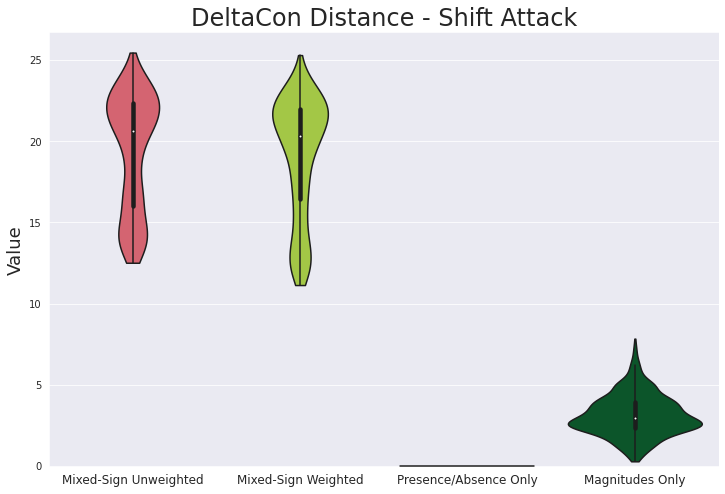

In [12]:
plot_attack_alts(random_matrices, shift_attack, title='DeltaCon Distance - Shift Attack')

## Magnitude Swap Attack

Replace $n$'th largest entry of matrix (in terms of absolute value) with $n$'th smallest for all $n$ (same also as replacing $n$'th smallest with $n$'th largest for all $n$), while leaving the signs exactly the same.

In [13]:
def magnitude_attack(matrix):
    nonzero_indices = np.nonzero(matrix)
    nonzero_entries = matrix[nonzero_indices]
    
    signs = np.sign(nonzero_entries)
    magnitudes = np.abs(nonzero_entries)
    
    # note how/why (np.sort(vector))[np.argsort(np.argsort(vector))] is the same as vector
    # each entry of np.argsort(np.argsort(vector)) gives the relative size of the corresponding
    # entry of vector, for example if its `i`th entry is 7, then the `i`th entry of vector is
    # the (7+1)'th smallest. If we instead want the `i`th entry to be the (7+1)'th largest,
    # we do the following (note that [::-1] is equivalent to `np.flip` for a 1D array):
    attacked_magnitudes = (np.sort(magnitudes)[::-1])[np.argsort(np.argsort(magnitudes))]
    
    attacked_matrix = np.zeros(matrix.shape)
    attacked_matrix[nonzero_indices] = signs * attacked_magnitudes
    return attacked_matrix

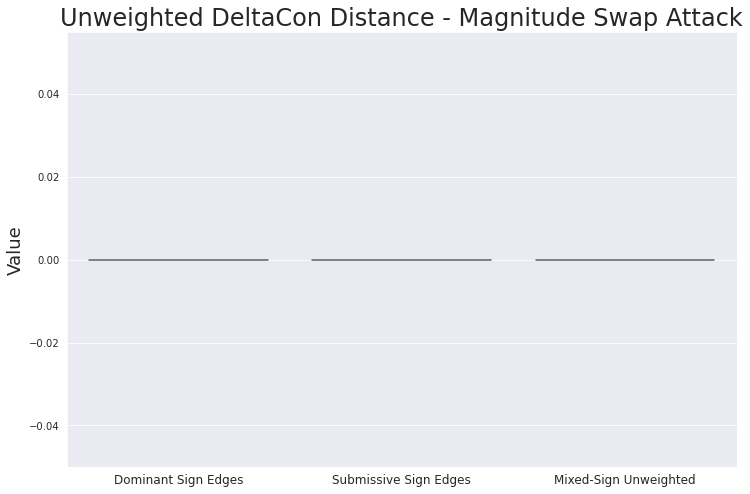

In [14]:
plot_attack_u_variants(random_matrices, magnitude_attack, 'Unweighted DeltaCon Distance - Magnitude Swap Attack')

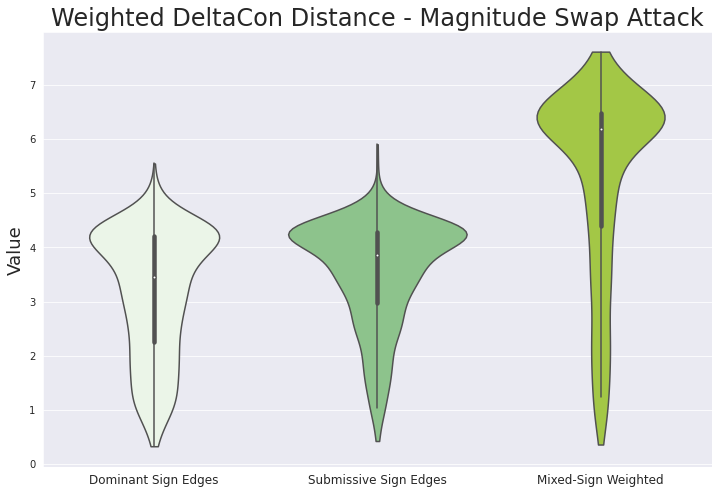

In [15]:
plot_attack_w_variants(random_matrices, magnitude_attack, 'Weighted DeltaCon Distance - Magnitude Swap Attack')

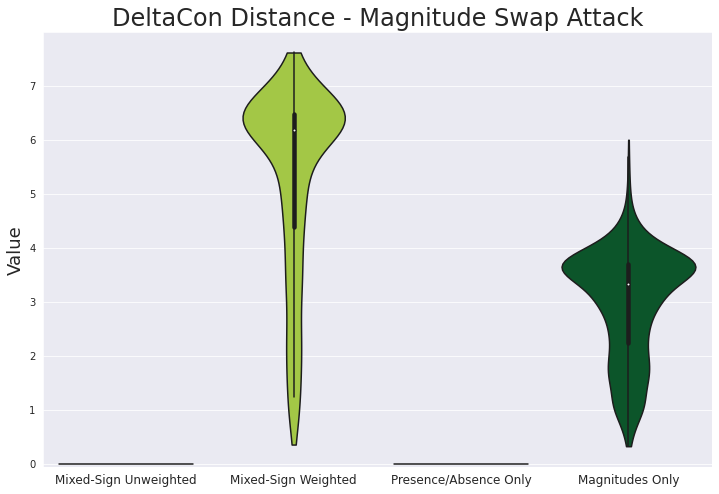

In [16]:
plot_attack_alts(random_matrices, magnitude_attack, 'DeltaCon Distance - Magnitude Swap Attack')

## Sign Flip Attack

In [17]:
def sign_attack(matrix):
    num_neg = np.sum(matrix < 0)
    num_pos = np.sum(matrix > 0)
    
    if num_neg > num_pos:
        result = np.where(matrix > 0, matrix, -matrix)
    if num_pos > num_neg:
        result = np.where(matrix < 0, matrix, -matrix)
        
    return result

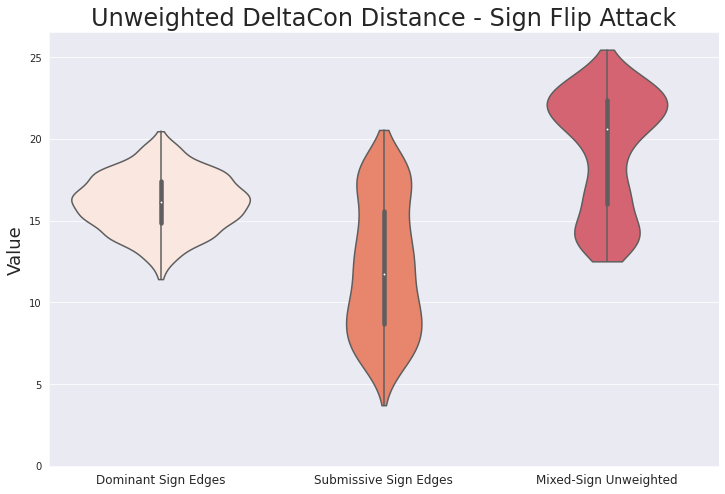

In [18]:
plot_attack_u_variants(random_matrices, sign_attack, 'Unweighted DeltaCon Distance - Sign Flip Attack')

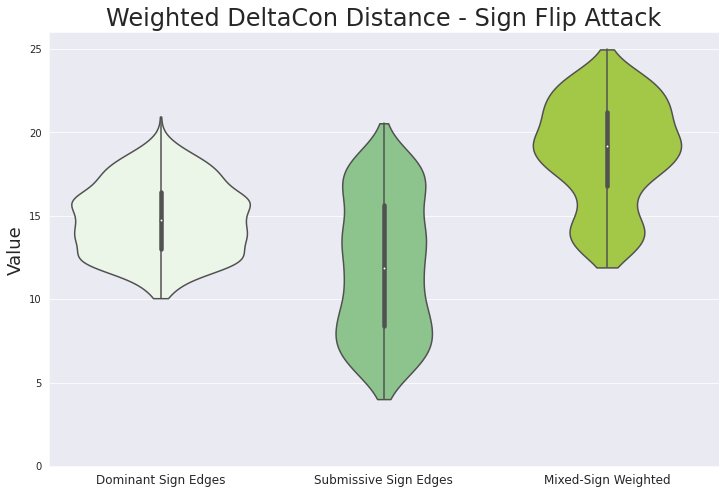

In [19]:
plot_attack_w_variants(random_matrices, sign_attack, 'Weighted DeltaCon Distance - Sign Flip Attack')

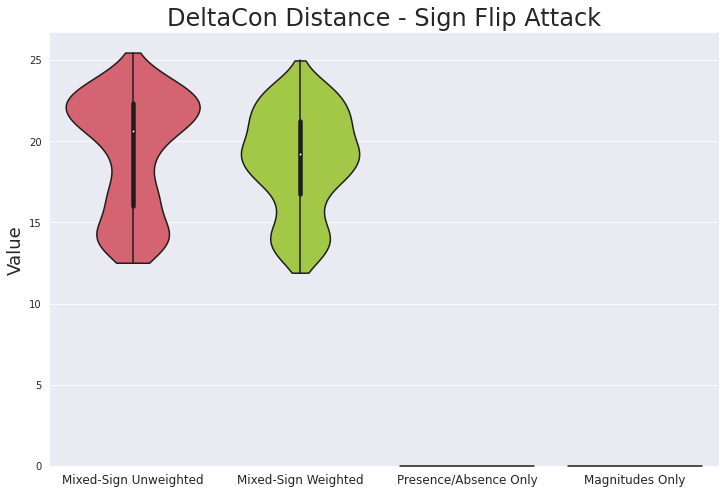

In [20]:
plot_attack_alts(random_matrices, sign_attack, 'DeltaCon Distance - Sign Flip Attack')